<a href="https://colab.research.google.com/github/prayas99/SoS-2020-/blob/master/SoC_IDS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import seaborn as sns
import matplotlib.pyplot as plt

In [1245]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#df = pd.read_csv("annthyroid.csv",header = 0) don't use header=0 as it tells pandas to use first row as headers
list1 = ['A','B','C','D','E','F','label']
df = pd.read_csv('/content/drive/My Drive/annthyroid.csv',names=list1)

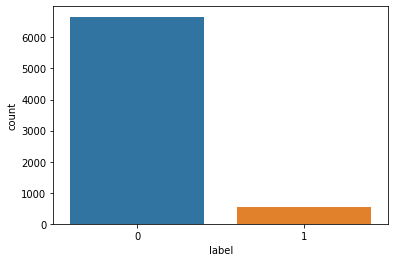

In [1247]:
sns.countplot(x = 'label', data=df)

In [0]:
d_input = df.iloc[:,:7]

In [1249]:
d_input.head()

,A,B,C,D,E,F,label
0,0.73,0.00060,0.015,0.120,0.082,0.146,0
1,0.24,0.00025,0.030,0.143,0.133,0.108,0
2,0.47,0.00190,0.024,0.102,0.131,0.078,0
3,0.64,0.00090,0.017,0.077,0.090,0.085,0
4,0.23,0.00025,0.026,0.139,0.090,0.153,0


In [0]:
class ExampleDataset(Dataset):
    def __init__(self, data):
        self.data = data
 
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [1251]:
dataset = ExampleDataset(d_input)
# dataset.len() Error!
len(dataset) # Correct

7200

In [1252]:
train, test = train_test_split(d_input, test_size=0.02)
len(train)

7056

In [0]:
traindf = ExampleDataset(train)
testdf = ExampleDataset(test)

In [1254]:
train.head()

,A,B,C,D,E,F,label
577,0.64,0.00189,0.0206,0.11118,0.099,0.11207,0
2053,0.44,0.02100,0.0206,0.07600,0.090,0.08400,0
3890,0.28,0.00460,0.0150,0.09200,0.102,0.09000,0
1440,0.62,0.00240,0.0200,0.10300,0.095,0.10900,0
2911,0.35,0.00003,0.0170,0.11400,0.098,0.11500,0


In [0]:
train_labels = train.iloc[:, 6]
train_inputs = train.iloc[:, :6]
test_labels = test.iloc[:, 6]
test_inputs = test.iloc[:, :6]

In [0]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [0]:
train_target = torch.tensor(train_labels.values.astype(np.float32)) 
train = torch.tensor(train_inputs.values.astype(np.float32)) 

train = normalize(train)
train_target = normalize(train_target)

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 64, shuffle = True)

In [0]:
test_target = torch.tensor(test_labels.values.astype(np.float32))
test = torch.tensor(test_inputs.values.astype(np.float32)) 

test_tensor = data_utils.TensorDataset(test,test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 1, shuffle = False)

In [1259]:
print(test.size())
print(test_target.size())

torch.Size([144, 6])
torch.Size([144])


In [0]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 6.
        self.layer_1 = nn.Linear(6, 24) 
        self.layer_2 = nn.Linear(24, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(24)
        self.batchnorm2 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [1261]:
model = binaryClassification()
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

binaryClassification(
  (layer_1): Linear(in_features=6, out_features=24, bias=True)
  (layer_2): Linear(in_features=24, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [1263]:
model.train()
EPOCHS = 5
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        #print(y_pred.size())
        #print(y_batch.size())
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        #print(loss.size())
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 1: | Loss: 0.22480 | Acc: 92.586
Epoch 2: | Loss: 0.11175 | Acc: 95.775
Epoch 3: | Loss: 0.08786 | Acc: 96.360
Epoch 4: | Loss: 0.08459 | Acc: 96.225
Epoch 5: | Loss: 0.07550 | Acc: 96.874


In [0]:
#torch.save(model, 'weights_only_8.pth')
# 3 - 0.98 , 0.67
# 8 - 0.97 , 0.43

In [0]:
#model = binaryClassification()
#model = torch.load('weights_only_3.pth')

In [0]:
y_pred_list = []
y_correct = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        #y_pred_list.append(y_pred_tag.cpu().numpy())
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_correct.append(y_batch.numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_correct_list = [a.squeeze().tolist() for a in y_correct]

In [0]:
y_pred_ana = []
y_pred_non = []
temp1 = len(y_correct_list)
for i in range(0,temp1):
  if y_correct_list[i] == 1:
    y_pred_ana.append(y_pred_list[i])
  else:  
    y_pred_non.append(y_pred_list[i])

y_pred_non = [i * 100 for i in y_pred_non]
y_pred_ana = [i * 100 for i in y_pred_ana]

In [1268]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Text(0, 0.5, 'Occurences')

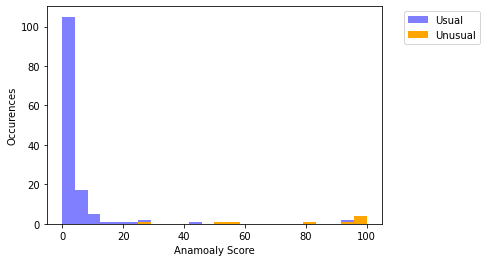

In [1269]:
data = y_pred_non
bins = np.linspace(0, 100, 25, endpoint=True)
plt.hist(data, bins,color = 'blue',alpha =0.5, label = 'Usual')

data1 = y_pred_ana
bins = np.linspace(0, 100, 25, endpoint=True)
plt.hist(data1, bins,color = 'orange', label = 'Unusual')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Anamoaly Score')
plt.ylabel('Occurences')

In [1270]:
from sklearn.metrics import confusion_matrix, classification_report

test_labels = np.array(test_labels)
y_pred_list = np.array(y_pred_list)


print(classification_report(test_labels, y_pred_list.round(), target_names=["Normal", "Abnormal"]))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       135
    Abnormal       0.80      0.89      0.84         9

    accuracy                           0.98       144
   macro avg       0.90      0.94      0.92       144
weighted avg       0.98      0.98      0.98       144

